<center>
<img src='https://camo.githubusercontent.com/88b0ce29beb6724c1ba363b7e025cfe33fb19baee23a88418d78fdc2ad9bc140/68747470733a2f2f7777772e71756f74656d61737465722e6f72672f696d616765732f36632f36636434343032613361343731646633346561346539323332666536643363642e6a7067' align='center' width="300x">
</center>

# Андан на экономе

## Семинар 7:  линейная регрессия, переобучение и регуляризация

В этом семинаре мы с вами продолжим погружаться в машинное обучение.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Линейная регрессия

На прошлом семенаре мы довольно подробно обсудили, как работает метод ближайших соседей. Для линейной регрессии мы только сформулировали модель. На этом давайте обсудим, как работает линейная регрессия. Для начала, подгрузим данные с прошлого семинара и оставим только количественные признаки.

In [2]:
df = pd.read_csv('Advertising.csv')
df.drop('Area', axis=1, inplace=True)
print(df.shape)
df.head()

(200, 4)


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


## 1.1 Как выглядит модель

Простая линейная регрессия - это подход к прогнозированию **количественной переменной** с использованием **одного признака**:

$y = w_0 + w_1x$

- $y$ это таргет
- $x$ это признак
- $w_0$ это свободный член
- $w_1$ это коэффициент при признаке x

Вместе $w_0$ and $w_1$ называются **коэффициентами модели**. Чтобы создать свою модель, вы должны "выучить" значения этих коэффициентов. И как только мы "выучим" эти коэффициенты, мы сможем использовать модель для прогнозирования продаж.

На прошлом семинаре мы делали это следующим образом.

In [3]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)

y_train = df_train['Sales']
y_test = df_test['Sales']

X_train = df_train[['TV']]
X_test = df_test[['TV']]

In [4]:
#Что хотим увидеть
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

model_regression.coef_, model_regression.intercept_

(array([0.04652973]), 7.119638430592953)

Допустим, появился новый рынок, на котором расходы на телевизионную рекламу составили **$50,000**. Что бы мы спрогнозировали для продаж на этом рынке?

$$
\hat y = \hat w_0 + \hat w_1 \cdot x =  7.1194 + 0.0465 \cdot 50
$$

In [5]:
X_new = pd.DataFrame({'TV': [50]})
X_new.head()

,TV
0,50


In [6]:
model_regression.predict(X_new)

array([9.44612512])

In [7]:
7.1194 + 0.0465 * 50

9.4444

Можно построить прогнозы сразу на всей тестовой выборке.

In [8]:
y_pred_regr = model_regression.predict(X_test)
y_pred_regr

array([14.71794394, 16.2115484 , 20.74819743,  7.66403631, 17.37013877,
       10.61402143, 17.2072847 ,  9.44612512, 17.46785121, 15.2669948 ,
        8.58532504,  9.73460946, 18.03086098,  7.37089899, 13.61053628,
       15.03899911,  7.45930549, 16.31391381, 10.62332738, 18.16579721,
       17.79821232, 10.27435438,  8.88776831, 18.79394862, 10.33019006,
        9.60897918, 17.05373658, 13.60123034, 11.17703121,  7.51048819,
       16.41627922, 10.339496  , 16.37440246,  7.90599093, 20.18053468,
       18.203021  ,  9.36702457, 19.85482655, 12.57292322,  8.39920611])

Построим наши прогнозы на графике.

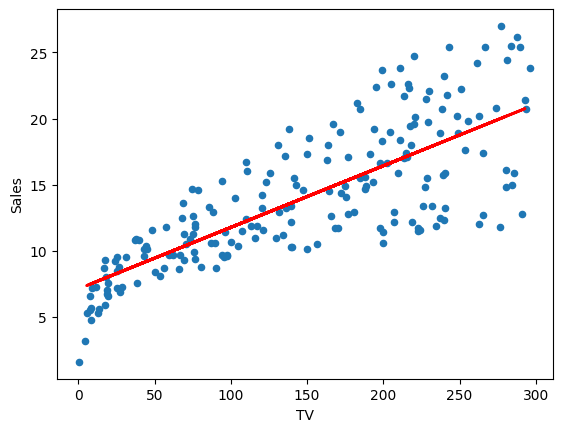

In [9]:
df.plot(kind='scatter', x='TV', y='Sales')

plt.plot(X_test, y_pred_regr, c='red', linewidth=2)
plt.show()

## 1.2 Как обучается модель?

Метод `.fit` обучает коэффициенты модели. Он пытается подобрать неизвестные коэффициенты так, чтобы минимизироать ошибку. Обычно, это средняя квадратичная ошибка. На картинке это выглядит так:

<center>
<img src='images/estimating_coefficients.png' align='center' width="600x">
</center>

- Черные точки - это **наблюдаемые значения** x и y.
- Синяя линия - это наша **линия полученная при минимизации квадратов ошибок**.
- Красные линии - это **остатки**, которые представляют собой расстояния между наблюдаемыми значениями и линией регрессии.

Давайте посмотрим как идёт оптимизация на простом примере. Удалим константу и рассмотрим модел с одним регрессором. 

__Модель:__ 

$$
y_i = w \cdot x_i
$$

__Функция потерь:__

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat y_i)^2 =  \frac{1}{n} \sum_{i=1}^n (y_i - w \cdot x_i)^2 \to \min_{w}
$$

Попробуем найти оптимальное $w$ как на матане, взяв производную и приравняв её к нулю. 

$$
\frac{\partial MSE}{\partial w} = - \frac{2}{n} \sum_{i=1}^n (y_i - w \cdot x_i) x_i = 0
$$

__Решение:__

$$
\hat{w} = \frac{ \sum x_i y_i }{ \sum x^2_i}
$$

In [10]:
model_regression = LinearRegression(fit_intercept=False) 
model_regression.fit(X_train, y_train)
model_regression.coef_

array([0.0826285])

In [11]:
np.sum(X_train['TV'].values * y_train.values )/np.sum(X_train['TV'].values**2)

0.08262850261766855

Мы смогли получить решение модели в явном виде. Такое бывает очень редко. В случае регрессии мы можем оптимизировать другую функцию потерь, отличную от MSE. Например, MAE

$$
MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat y_i|.
$$

Для неё не существует аналитического решения. Из-за этого, модель обучают методом градиентного спуска. Если вкратце, то находят производную по параметру. Она указывает направление наискорейшего роста функции. Значит, если мы хотим идти в сторону минимума, нам надо двигаться в противоположном направлении. Тогда мы можем подбирать коэффициенты итеративно: 

1. Инициализируем случайно значение w_0
2. Находим производную функции потерь $\frac{\partial L}{\partial w}$
3. До тех пор, пока $|w_{t + 1} - w_t| > \varepsilon$ делаем шаги

$$
w_{t+1} = w_t - \eta_t \cdot \frac{\partial L}{\partial w}
$$

В качестве скорости обучение, $\eta_t$,  можно взять какую-нибудь константу. Например, $0.001$, либо подобрать это значение более умным образом.

Давайте попробуем это закодить!

In [14]:
y = y_train.values
x = X_train['TV'].values

In [15]:
def get_grad_mse(y, y_pred, w):
    n = len(y)
    return (-2/n) * np.sum(x * (y - y_pred)) 

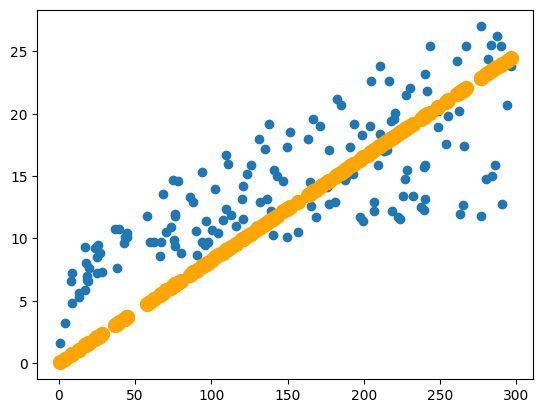

loss =  22.736345136392078


In [16]:
from IPython.display import clear_output

w = [0]     # тут будем запоминать траекторию из коэффициентов
eta = 1e-6  # скорость обучения

diff = 100  # изначальная разница между w_new и w_old (для остановки цикла)
tol = 1e-7  # разница при которой останавливаемся

i = 0
while diff > tol:
    i += 1
    y_pred = w[-1] * x              # прогнозы модели
    mse = np.mean((y - y_pred)**2)  # ошибка модели
    
    mse_grad = get_grad_mse(y, y_pred, w[-1]) # градиент по формуле
    w_new = w[-1] - eta * mse_grad            # шаг спуска 
    
    diff = np.abs(w_new - w[-1])  # новая разница между w_new и w_old
    w.append(w_new)
    
    # рисуем картинки
    if i % 5 == 0:
        clear_output(True)
        plt.scatter(x, y)
        plt.scatter(x, y_pred, color='orange', linewidth=5)
        plt.show()
        print("loss = ", mse)

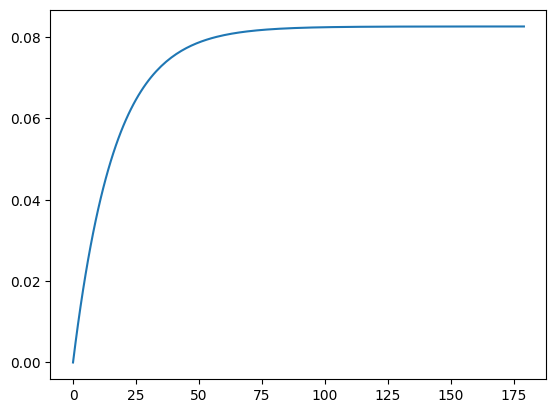

In [17]:
plt.plot(w);

- Подробнее про разные функции потерь, которые можно использовать для обучения линейных моделей можно почитать [в конспекте Жени Соколова,](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture02-linregr.pdf) про градиентный спуск тоже есть [отдельный конспект.](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture03-linregr.pdf)

- Дополнительно можно попытаться решить [ручную задачку на градиентный спуск из конспекта Фила](https://fulyankin.github.io/deep_learning_masha_book/problem_set_02_gradient/problem_01.html)

## 2. Переобучение

Часто, чтобы выша модель могла давать лучшие прогнозы, вам нужно добавить больше фичей, которые могли бы учесть некоторые зависимости в ваших данных. Например, добавив квадраты переменных, мы сможем учесть часть нелинейной зависимости. Если делать так бесконтрольно, можно **переобучиться.**

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: 

$$
\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01).
$$

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

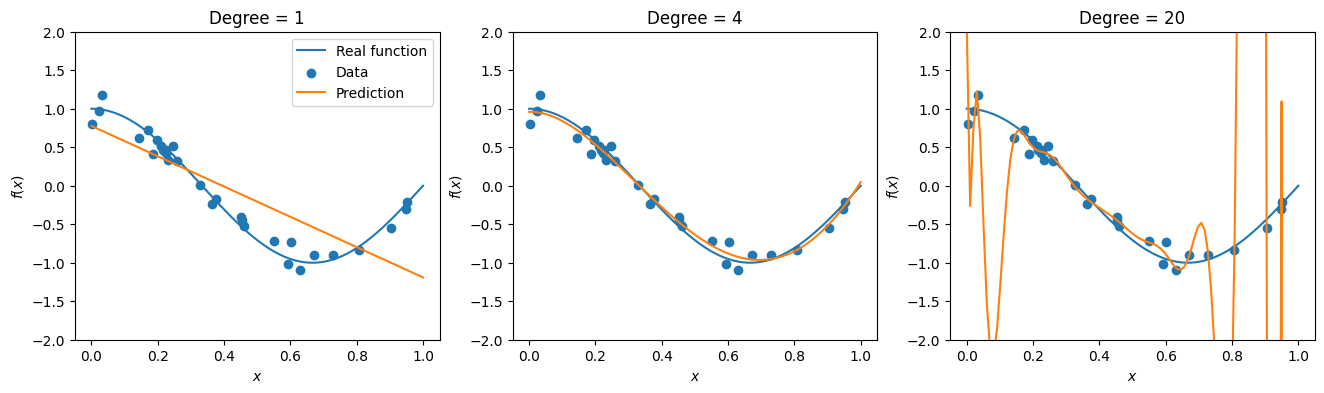

In [18]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

Первая модель недообучилась. Вторая модель неплохо описала процесс порождения данных. Третья модель переобучилась. Она попыталась вызубрить все точки из обучающей выборки и пройти через них. При этом никакой полезной информации о процессе порождения данных, модель не выучила. 

Мы можем детектировать переобучение с помощью тестовой выборки. __Как думаете, каким образом?__ 

Начнём всё с нуля, с новым датасетом. Воспользуемся набором данных с признаками по недвижимости для предсказания ее стоимости с Kaggle: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [19]:
df = pd.read_csv('train.csv', index_col=0)
print(df.shape)
df.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


`SalePrice` - наша таргетная (целевая) переменная. Полное описание всех 79 признаков можно посмотреть на [Kaggle.]

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

In [20]:
from sklearn.model_selection import train_test_split


y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])
feature_names = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Посмотрим на распределение целевой переменной.

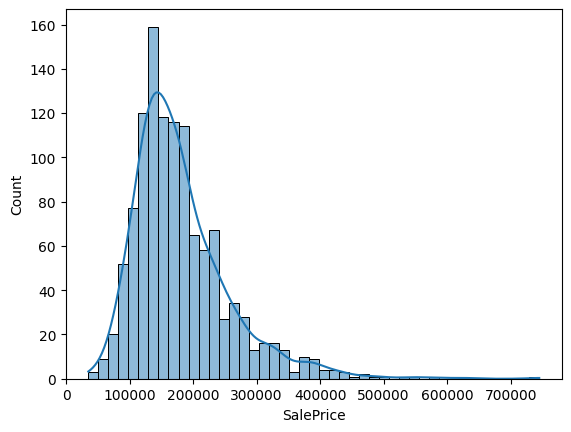

In [21]:
sns.histplot(y_train, kde=True);

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

__Вопрос:__ как можно почистить данные от выбросов? 

Давайте оставим в данных только численные переменные и заполним все пропуски средними. 

__Вопрос:__ зачем заполнять пропуски? Какие способы для этого есть?

In [22]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()  # считаем средние на трэйне
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)   # применяем к тесту средние с трэйна

__Вопрос:__ почему мы заполнили пропуски в тестовых данных средними с трэйна?

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

model = LinearRegression()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1347
Train MAPE = 0.1250


Если посмотреть на облака рассеивания, видно что между ценой и многими признаками есть нелинейные зависимости. 

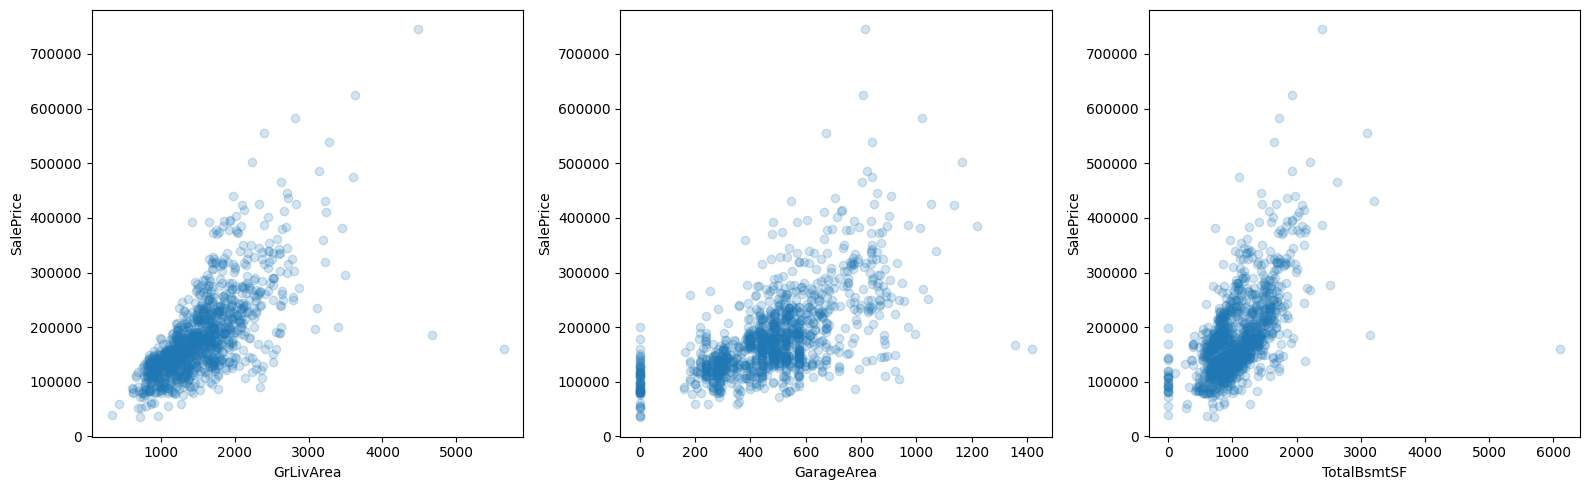

In [24]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Давайте добавим в данные степеней. 

In [25]:
polinom_transform = PolynomialFeatures(3, include_bias=False)

X_train_poly = polinom_transform.fit_transform(X_train[numeric_features])
X_test_poly = polinom_transform.transform(X_test[numeric_features])

In [26]:
X_train[numeric_features].shape

(1168, 36)

In [27]:
X_train_poly.shape

(1168, 9138)

In [28]:
y_train_pred.shape

(1168,)

In [29]:
model = LinearRegression()

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 1.4936
Train MAPE = 0.0000


__Вопрос:__ Что произошло с метриками качества? Видно ли по ним переобучение модели? Сможем ли мы успешно использовать такую модель на практике?

## 3. Кросс-валидация

Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [30]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, 
                            cv=10, scoring='neg_mean_absolute_percentage_error')

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.1253
	-0.1280
	-0.1273
	-0.1660
	-0.1621
	-0.1284
	-0.1328
	-0.1030
	-0.1192
	-0.1107
Mean CV MSE = 0.1303


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании (наивный прогноз).

In [31]:
best_constant = y_train.mean() 
mean_absolute_percentage_error(y_test, best_constant * np.ones(y_test.shape))

0.4135583143029261

In [32]:
best_constant = y_train.median() 
mean_absolute_percentage_error(y_test, best_constant * np.ones(y_test.shape))

0.3597429691242018

__Вопрос:__ почему медиана, используемая в качестве константы, показывает более хороший результат? Насколько сильно линейная регрессия улучшает наивный прогноз? 

## 4. Регуляризация

С переобучением можно бороться. В случае линейной регрессии, чтобы полином опутал все точки, нужно чтобы в уравнении были большие коэффиценты. Такой приём называется регуляризацией. О нём мы поговорим более подробно на следующем семинаре. 

## 5. Нормализация данных (скалирование)

Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [33]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

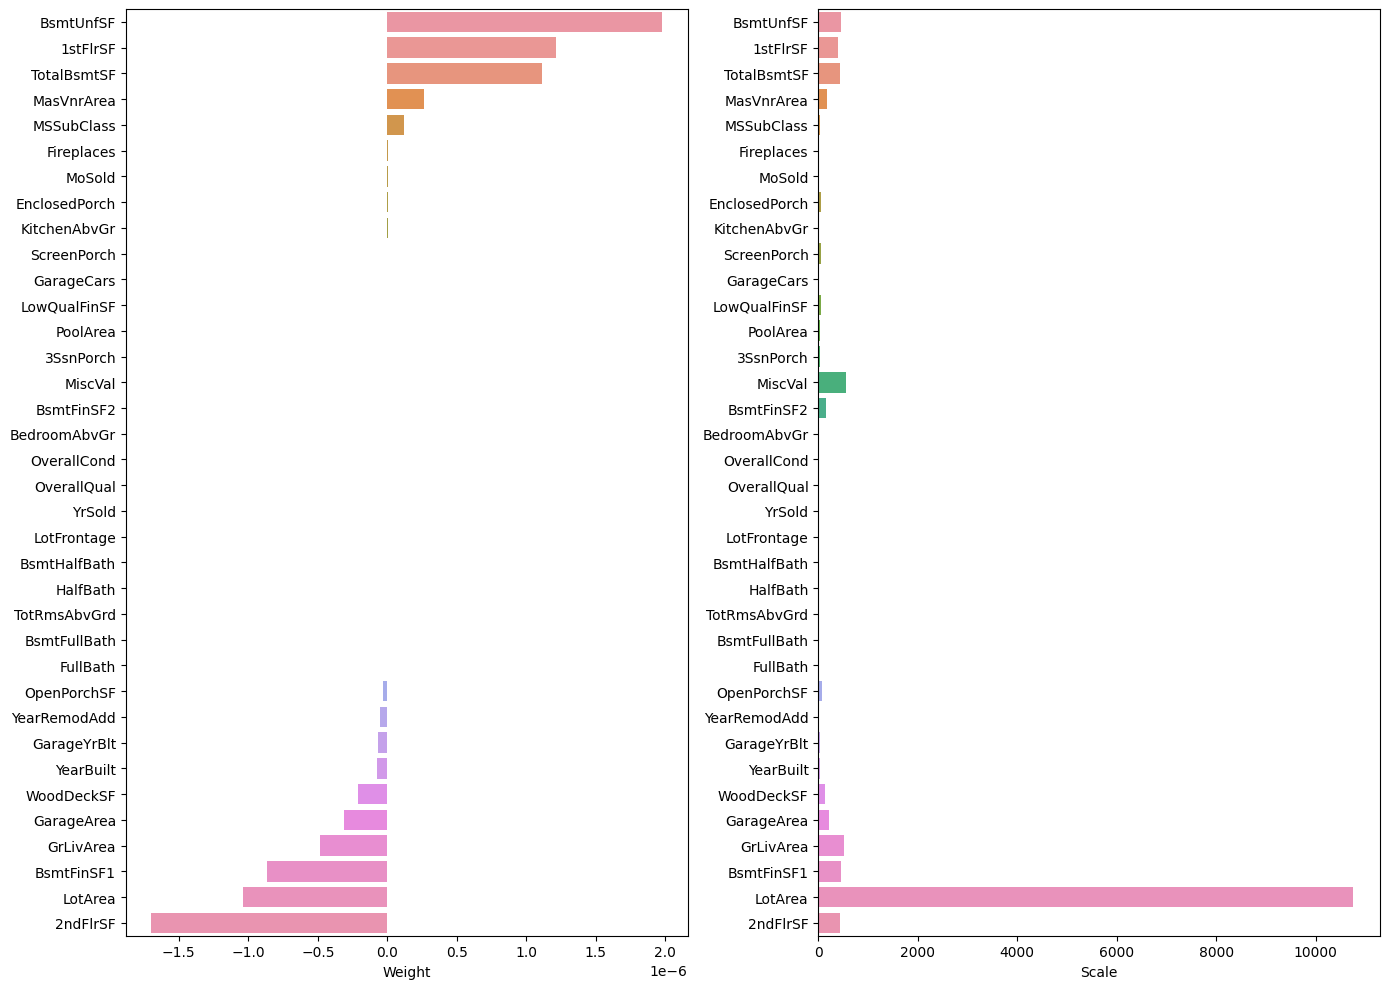

In [34]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

__Вопрос:__ мы уже пользовались масштабированием в методе ближайшего соседа. Почему это было там важно? 

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1347
Train MAPE = 0.1249


__Вопрос:__ почему мы обучаем `StandardScaler` на обучающей выборке, а к тестовой только применяем его?

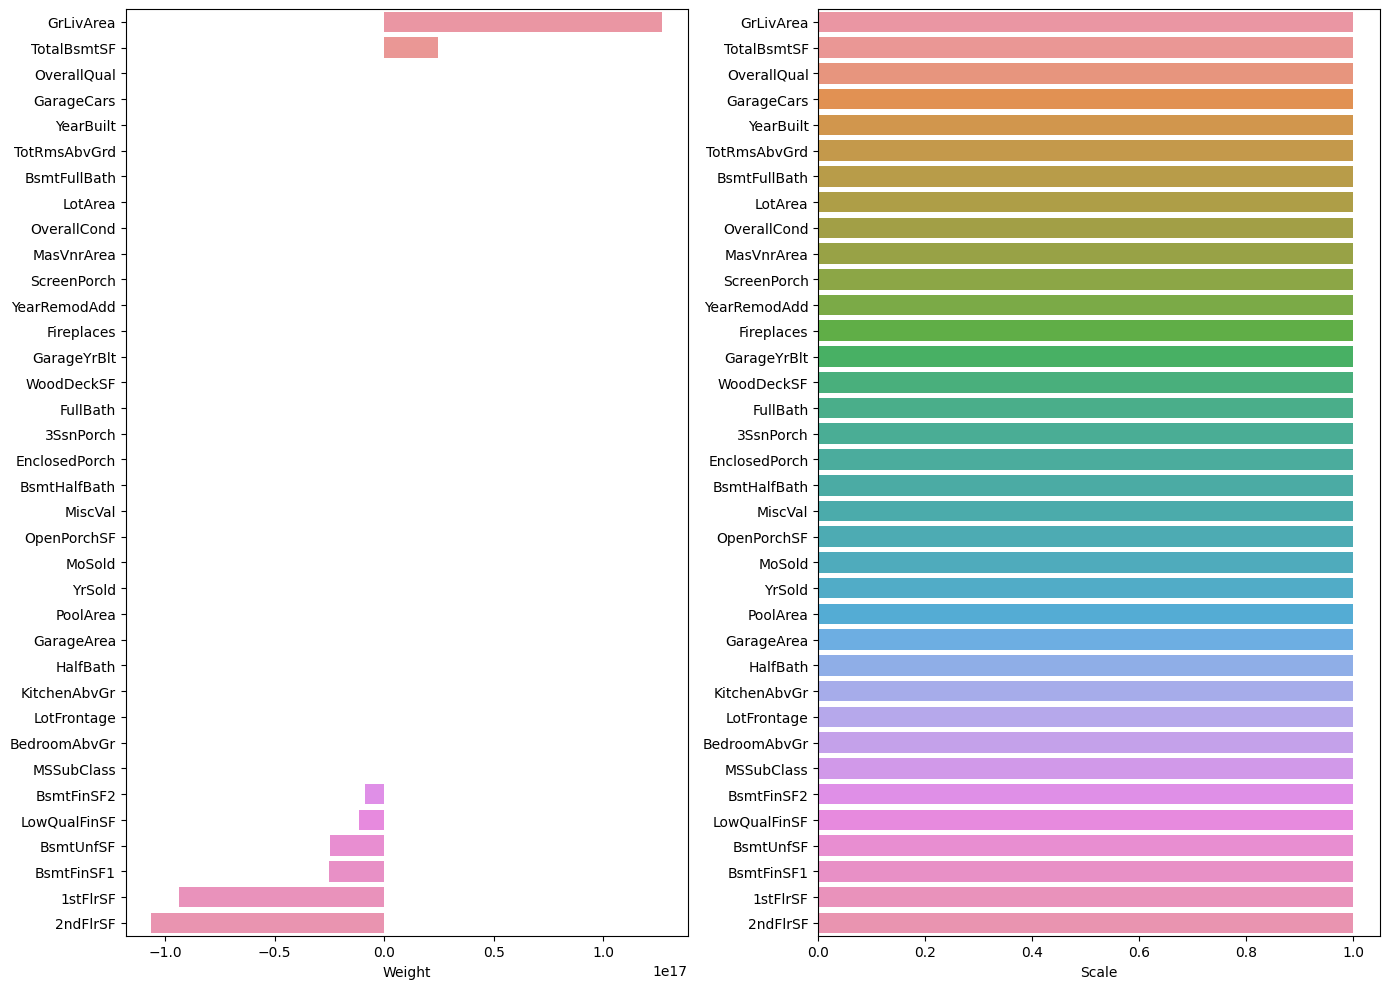

In [36]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

__Вопрос:__ что произошло с коэффициентом перед переменной `LotArea`?

По картинке выше мы можем сказать, какая из переменных вносит наибольший вклад в прогноз. Это один из способов интерпретации модели. Есть и другие. Например, в эконометрике вы будете пытаться искать несмещённые оценки коэффициентов в линейной регрессии и интерпретировать их немного в ином ключе. В машинном обучении на несмещённость и статистические свойства оценок, обычно, забивают. Более того, их даже стараются сделать смещёнными, чтобы улучшить прогнозы. Прогнозы для нас важнее всего.

## 6.  "Эр квадрат"

Напоследок давайте обсудим ещё одну метрику качества регрессии, которую часто используют на практике. Она называется коэффицент детерминации, $R^2$. Выше мы сказали, что было бы классно сравнить нашу модель с наивной моделью. Коэффициент детерминации позволяет сделать это в терминах метрики MSE. 

Лучшая константа, которая оптимизирует MSE &mdash; это среднее. Поэтому будем сравнивать модель с ним. 

<center>
<img src='images/r2.png' align='center' width="650x">
</center>

На картинке:

- красная линия &mdash; это прогноз наивной модели (среднее)
- чёрная линия &mdash; это прогноз линейной модели 
- $TSS$ &mdash; это средняя квадратичная ошибка наивной модели
- $RSS$ &mdash; это ошибка линейно модели
- $ESS$ &mdash; это разница между наивным и нашим прогнозами

Получается, что $\frac{RSS}{TSS}$ это ошибка линейной модели поделить на ошибку наивного прогноза. Это то, насколько наша модель плохо работает по сравнению с наивным прогнозом. Получается, если мы хотим получить метрику, говорящую о том, насколько наша модель оказалась лучше наивного прогноза, нужно посчитать 

$$
R^2 = 1 - \frac{RSS}{TSS} = \frac{ESS}{TSS}.
$$

На эконометрике вы будете интерпретировать $R^2$ с точки зрения дисперсия, а не сравнения с наивной моделью.

In [37]:
from sklearn.metrics import r2_score

print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test R2 = 0.8232
Train R2 = 0.8070


## Ссылки

- Этот семинар основан на [семинаре про линеные модели с ФКН,](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem02-sklearn-linregr.ipynb) а также [вот этой тетрадке](https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb)
- Картинка про $R^2$ утащена из [видоса Фила](https://www.youtube.com/watch?v=OhKVEDPvtPw&list=PLCf-cQCe1FRw6XWyfIfL84-W-BVz9Q8js&index=10)